In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score

import itertools

from pmdarima import auto_arima

from pandas.tseries.offsets import DateOffset
  

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('DailyDelhiClimateTrain.csv')
df_train

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [3]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(temp):
    result = adfuller(temp)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value, label in zip(result, labels):
        print(label, ':', str(value))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        

In [5]:
adfuller_test(df_train['meantemp'])

ADF Test Statistic : -2.0210690559206728
p-value : 0.27741213723016056
#Lags Used : 10
Number of Observations Used : 1451
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


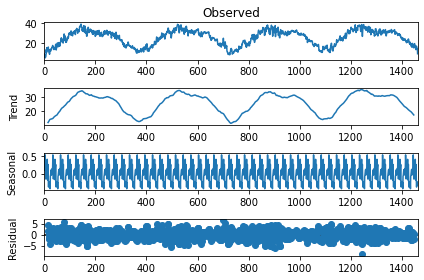

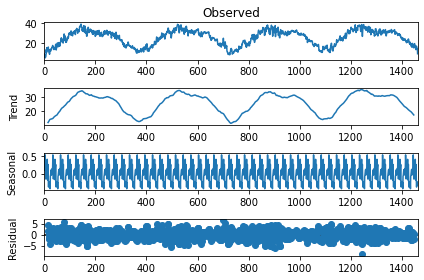

In [10]:
result = seasonal_decompose(df_train['meantemp'].values, model='additive', period = 30)
result.plot()

In [12]:
df_train["diff_1"] = df_train["meantemp"].diff(periods=1)
df_train["diff_2"] = df_train["meantemp"].diff(periods=2)
df_train["diff_3"] = df_train["meantemp"].diff(periods=3)

In [13]:
df_train.head()

,date,meantemp,humidity,wind_speed,meanpressure,diff_1,diff_2,diff_3
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,NaN,NaN,NaN
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,-2.600000,NaN,NaN
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,-0.233333,-2.833333,NaN
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,1.500000,1.266667,-1.333333
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,-2.666667,-1.166667,-1.400000


In [15]:
adfuller_test(df_train['diff_1'].dropna())

ADF Test Statistic : -16.378720267074687
p-value : 2.764863137594565e-29
#Lags Used : 9
Number of Observations Used : 1451
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [27]:
#using auto arima
stepwise_fit = auto_arima(df_train['meantemp'], start_p = 1, start_q = 1,
                          max_p = 8, max_q = 8, d= 1, D = 1, max_P=6, max_Q=6,
                           seasonal = True, stationary = False,
                          trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5544.460, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5650.181, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5614.068, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5602.114, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5648.181, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5546.100, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5546.168, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5573.723, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5600.849, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5546.314, Time=1.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5542.478, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5600.115, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5612.068, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5544.118, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1462
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2768.239
Date:                Thu, 11 May 2023   AIC                           5542.478
Time:                        10:17:32   BIC                           5558.339
Sample:                             0   HQIC                          5548.395
                               - 1462                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5728      0.046     12.494      0.000       0.483       0.663
ma.L1         -0.8028      0.036    -22.070      0.000      -0.874      -0.731
sigma2         2.5896      0.072     36.204      0.000       2.449       2.730
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               255.47
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -0.46
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
#using iteration method
p = range(0,8)
q = range(0, 8)
d = range(0, 2)

order_final = []
r2_list = []

pdq_comb = list(itertools.product(p,d,q))

len(pdq_comb)

128

In [19]:
for pdq in pdq_comb:
    try:
        model = ARIMA(df_train['meantemp'], order = pdq).fit()    
        pred = model.predict(start = int(len(df_train)*0.8))                                  
        r2 = r2_score(df_train['meantemp'][int(len(df_train)*0.8):], pred)
        order_final.append(pdq)
        r2_list.append(r2)
    except:
        continue

In [20]:
df_results = pd.DataFrame({'Order':order_final, 'R2_score':r2_list})
df_results

,Order,R2_score
0,"(0, 0, 0)",-0.436842
1,"(0, 0, 1)",0.474544
2,"(0, 0, 2)",0.702279
3,"(0, 0, 3)",0.800249
4,"(0, 0, 4)",0.839068
...,...,...
123,"(7, 1, 3)",0.920263
124,"(7, 1, 4)",0.921279
125,"(7, 1, 5)",0.924105
126,"(7, 1, 6)",0.920076


In [21]:
df_results_final = df_results[df_results['R2_score'] == df_results['R2_score'].max()]
df_results_final

,Order,R2_score
125,"(7, 1, 5)",0.924105


In [23]:
model = ARIMA(df_train['meantemp'], order = (7,1,5))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               meantemp   No. Observations:                 1462
Model:                 ARIMA(7, 1, 5)   Log Likelihood               -2747.597
Date:                Thu, 11 May 2023   AIC                           5521.194
Time:                        10:09:49   BIC                           5589.923
Sample:                             0   HQIC                          5546.832
                               - 1462                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3443      0.078      4.428      0.000       0.192       0.497
ar.L2          0.2702      0.100      2.695      0.007       0.074       0.467
ar.L3          0.2923      0.082      3.569      0.000       0.132       0.453
ar.L4          0.7161      0.102      7.053      0.000       0.517       0.915
ar.L5         -0.6826      0.054    -12.540      0.000      -0.789      -0.576
ar.L6         -0.0464      0.025     -1.824      0.068      -0.096       0.003
ar.L7          0.0748      0.028      2.650      0.008       0.019       0.130
ma.L1         -0.5839      0.073     -7.995      0.000      -0.727      -0.441
ma.L2         -0.2858      0.112     -2.563      0.010      -0.504      -0.067
ma.L3         -0.3507      0.090     -3.903      0.000      -0.527      -0.175
ma.L4         -0.6511      0.113     -5.763      0.000      -0.873      -0.430
ma.L5          0.8987      0.068     13.207      0.000       0.765       1.032
sigma2         2.5446      0.077     32.939      0.000       2.393       2.696
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               272.15
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -0.53
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

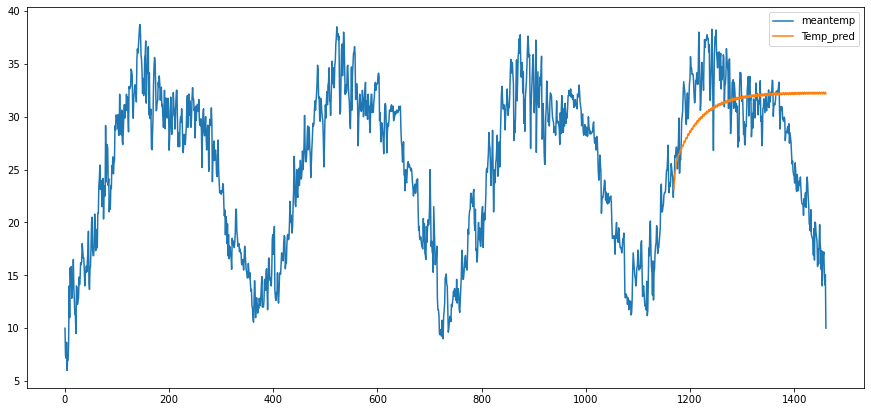

In [25]:
df_train['Temp_pred'] = model_fit.predict(start = int(len(df_train)*0.8), dynamic = True)
df_train[['meantemp', 'Temp_pred']].plot(figsize = (15, 7))